In [20]:
import numpy as np
import pandas as pd
from pregel import Vertex, Pregel
import matplotlib.pyplot as plt

### Reading the data for all the transactions

In [21]:
payments = pd.read_excel("Payments.xlsx")
payments

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396
...,...,...,...
130530,1344,1390,21739
130531,1914,1390,3374
130532,1914,1390,5186
130533,1914,1390,1559


### Reading the data for the bad traders

In [22]:
bad = pd.read_excel("bad_sender.xlsx")
bad

,Bad Sender
0,1303
1,1259
2,1562
3,1147
4,1393
5,1031
6,1210
7,1042
8,1048
9,1256


### Getting the data for all the traders involved in any kind of transaction

In [23]:
payments = payments.values.tolist()
bad = bad.values.tolist()
senders = []
receivers = []
for i in payments:
    senders.append(i[0])
    receivers.append(i[1])
all_traders = list(set(senders + receivers))
all_traders.sort()
# all_traders
len(all_traders)

799

### Making the graph for the transactions

In [24]:
# stores the corresponding total amount for a sender-receiver pair i.e (sender, receiver) -> total amount
transactions = {}

# stores all the receivers for a sender i.e sender -> list of receivers
edges = {}
for sender, receiver, amount in payments:
    if sender not in edges:
        edges[sender] = []
    edges[sender].append(receiver)
    key = (sender, receiver)
    if key not in transactions:
        transactions[key] = 0
    transactions[key] += amount

for key in edges.keys():
    edges[key] = list(set(edges[key]))

# adding an edge between vertices with no edge and bad nodes with equal weights
for trader in all_traders:
    if trader not in senders:
        edges[trader] = []
        for bad_trader in bad:
            edges[trader].append(bad_trader[0])
        for bad_trader in bad:
            key = (trader, bad_trader[0])
            transactions[key] = 1  

### Class for computing TrustRank

In [25]:
class TrustRankVertex(Vertex):

    # constructor for the class
    def __init__(self , id , value , out_vertices , outgoing_weights, initial_value ,dampingFactor=0.85,iterations=50):

        # calling the constructor of the parent class
        Vertex.__init__(self,id,value,out_vertices)
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations
        self.initial_value = initial_value
        self.outgoing_weights = outgoing_weights
        self.out_vertices = out_vertices

    def update(self):
        # This routine has a bug when there are pages with no outgoing
        # links (never the case for our tests).  This problem can be
        # solved by introducing Aggregators into the Pregel framework,
        # but as an initial demonstration this works fine.

        if self.superstep < self.num_supersteps:
            messages_sum = 0
            
            for (vertex,message) in self.incoming_messages:
                messages_sum +=message

            # we use a biased PageRank algorithm that gives the static score of 0
            # if it is a good node and a static score of 1/num_bad_nodes if it is a bad node
            # note that here we compute the Bad Score             
            self.value = (1-self.dampingFactor)*self.initial_value
            self.value += self.dampingFactor * messages_sum

            #calculating the outgoing messages for a vertex which stores weight
            self.outgoing_messages = []
            for vertex in self.out_vertices:
                weight = self.value * (self.outgoing_weights[vertex.id])
                self.outgoing_messages.append((vertex, weight))
        
        else:
            self.active = False

### Initialzing the vertices for the TrustRankVertex class

In [26]:
vertices = []
trust_rank = {}

# each node starts with a score of 1/N if its a bad node else 0
for trader in all_traders:
    trust_rank[trader] = 0;
    if [trader] in bad:
        trust_rank[trader] = 1/len(bad)
        
# initializing the class objects
for trader in all_traders:
    initial_value = 0
    if [trader] in bad:
        initial_value = 1/len(bad)
    vertices.append(TrustRankVertex(trader , trust_rank[trader] , [] , {} , initial_value, 0.85 , 50))

# calculating the outgoing weights for all the vertices to their receivers.
for v1 in vertices:
    total_weight = 0;
    for v2 in edges[v1.id]:
        total_weight += transactions[(v1.id, v2)]
    for v2 in vertices:
        if v2.id in edges[v1.id]:
            v1.out_vertices.append(v2)
            v1.outgoing_weights[v2.id] = transactions[(v1.id, v2.id)]/total_weight
            



### Running the Algorithm

In [27]:

p = Pregel(vertices,4)
p.run()
bad_scores = {}
scores = []
for v in p.vertices:
    bad_scores[v.id] = v.value
    scores.append(v.value)
result = []
for trader in all_traders:
    result.append([trader , bad_scores[trader]])

result = sorted(result, key = lambda x: x[1], reverse = True)
final_df = pd.DataFrame(result , columns=['Trader ID' , 'Bad Score'])

final_df.to_csv('Results_bad_score.csv' , index=False)

### Top 20 bad traders

In [28]:
print("The top 20 bad traders with their bad scores are: ")
print(final_df.head(20))

The top 20 bad traders with their bad scores are: 
    Trader ID  Bad Score
0        1007   0.039906
1        1088   0.034833
2        1144   0.034240
3        1210   0.030062
4        1042   0.023492
5        1086   0.023086
6        1034   0.017966
7        1076   0.016779
8        1048   0.015109
9        1099   0.014820
10       1147   0.014205
11       1205   0.013872
12       1626   0.013170
13       1201   0.012634
14       1094   0.012458
15       1011   0.012446
16       1173   0.012441
17       1480   0.012313
18       1013   0.011981
19       1084   0.011171


### Plots

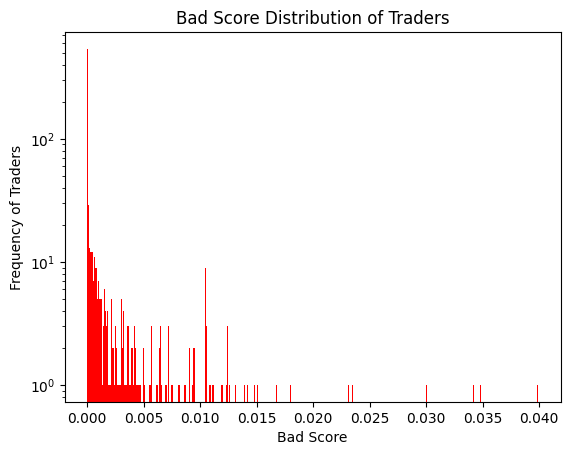

In [29]:
# plotting the histogram for bad score distribution
plt.hist(scores , bins = 'auto' , color = 'r')
plt.yscale('log')
plt.title("Bad Score Distribution of Traders")
plt.xlabel("Bad Score")
plt.ylabel("Frequency of Traders")
plt.savefig("hist.png")
plt.show()

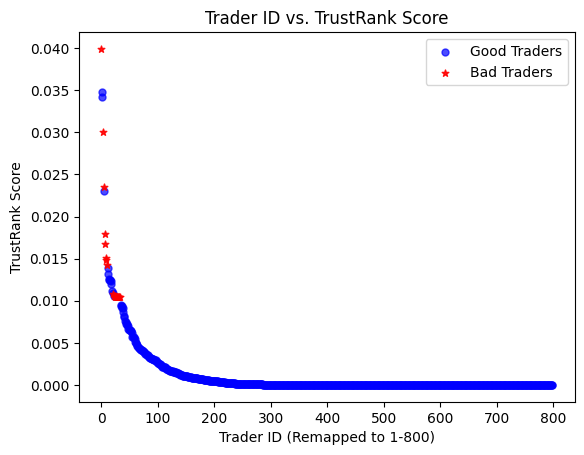

In [30]:
# Separate bad and good traders
bad_x = [i for i in range(len(result)) if [result[i][0]] in bad]
bad_y = [result[i][1] for i in range(len(result)) if [result[i][0]] in bad]

good_x = [i for i in range(len(result)) if [result[i][0]] not in bad]
good_y = [result[i][1] for i in range(len(result)) if [result[i][0]] not in bad]

# Plot good traders (circles)
plt.scatter(good_x, good_y, label="Good Traders", color="blue", marker="o", s=25, alpha=0.7)

# Plot bad traders (stars)
plt.scatter(bad_x, bad_y, label="Bad Traders", color="red", marker="*", s=25, alpha=0.9)

plt.xlabel("Trader ID (Remapped to 1-800)")
plt.ylabel("TrustRank Score")
plt.title("Trader ID vs. TrustRank Score")
plt.legend()
plt.savefig("scatter.png")

plt.show()